# Trades

All trade representations in `gs_quant` are part of the `Instrument` package. `Instrument` is used to represent any financial object that can be priced - like a derivative. See the [Instruments Guide](https://developer.gs.com/docs/gsquant/guides/Pricing-and-Risk/instruments/) for more information. 

All externally supported instruments are listed in the [supported instruments](https://developer.gs.com/docs/gsquant/guides/Pricing-and-Risk/instruments/#supported-instruments) section of the page. The remainder of the notebooks in this folders show case the available instruments by asset asset.

## Instrument Properties

Each instrument takes a number of properties as defined by it's signature. Instrument signatures are available [here](https://developer.gs.com/docs/gsquant/api/instrument.html#instruments/). For examples, an `IRSwap` has properties like `notional_currency` and `termination_date`. Let's define an `IRSwap` as example to explore the basics on. The asset class specific guides walk through how to define each instrument.

In [64]:
from gs_quant.instrument import IRSwap # import instruments
from gs_quant.common import PayReceive, Currency # import constants

my_swap = IRSwap(PayReceive.Pay, '5y', Currency.USD ) # 5y USD payer

### Getting a Property

Once an instrument is defined, a property can be called on the instrument. For example:

In [56]:
my_swap.termination_date

'5y'

### Setting a Property

Properties can be set using the same framework:

In [57]:
my_swap.termination_date = '1y' # change termination 10y
my_swap.termination_date

'1y'

In [58]:
my_swap.notional_amount = 5e6 # set notional amount
my_swap.notional_amount 

5000000.0

### Viewing Properties

Any set properties can be viewed using `as_dict()`

In [59]:
my_swap.as_dict()

{'notional_currency': USD,
 'pay_or_receive': Pay,
 'asset_class': Rates,
 'notional_amount': 5000000.0,
 'termination_date': '1y',
 'type': Swap,
 'fee': 0}

### Enum Properties
Some of the available properties are enums available in the common modules. You can use autocomplete (tab) to see all available values like `Currency` in the example above.

## Resolving 

The above output shows only the parameters specified, many of which are relative (i.e. expiration date, strike) but additional fields are needed to price the instrument. Calling the `resolve()` method will resolve any relative parameters to absolute values as well as fill in any defaulted parameters using the `PricingContext`. More on `PricingContext` [here](https://developer.gs.com/docs/gsquant/guides/Pricing-and-Risk/pricing-context/).

In [68]:
my_swap.resolve(in_place=False).as_dict()

{'fixed_rate_business_day_convention': Modified Following,
 'effective_date': '2019-11-21',
 'fixed_rate_day_count_fraction': 30/360,
 'notional_currency': USD,
 'pay_or_receive': Pay,
 'floating_rate_business_day_convention': Modified Following,
 'floating_rate_frequency': '3m',
 'asset_class': Rates,
 'notional_amount': 1000000.0,
 'floating_rate_day_count_fraction': ACT/360,
 'termination_date': '2024-11-21',
 'floating_rate_spread': 0.0,
 'type': Swap,
 'fixed_rate': 0.015759407491421337,
 'fee': 0.0,
 'fixed_rate_frequency': '6m',
 'floating_rate_option': 'USD-LIBOR-BBA',
 'floating_rate_designated_maturity': '3m'}

Note `resolve()` will change the state of the instrument object in place by default unless `in_place=False` like in the example above.

In the example above `resolve()` changes several specified relative parameters - for example `termination_date` transforms `10y` into a date as well as adds any unspecified default parameters - like `fixed_rate` and `effective date`.

### When to Use Resolve

`resolve` can be used to "fix" the instrument parameters when evaluating pricing & risk. If you do not resolve and evaluate the instrument under a pricing context, it will be resolved under that pricing context. For example, if the `termination_date` is `1y`, the unresolved swap it will be `1y` from each date vs in the resolved it will always be the same specific date.

To illustrate the point, let's price the swap above in both states (resolved and unresolved) and examine the difference in price:

In [66]:
from gs_quant.risk import HistoricalPricingContext
from datetime import timedelta, date
from copy import copy

end_date = date.today()
start_date = end_date - timedelta(days=33)

fixed_swap = copy(my_swap)
fixed_swap.resolve() # "fix" the parameters of this swap

with HistoricalPricingContext(start_date, end_date):
    d_price = my_swap.price()
    f_price = fixed_swap.price()
    
dynamic_price = d_price.result()
fixed_price = f_price.result()

Let's now plot the difference in price between the price of the swap with the fixed parameters and swap with changing parameters. As we can see below, there is a relatively significant difference in price.

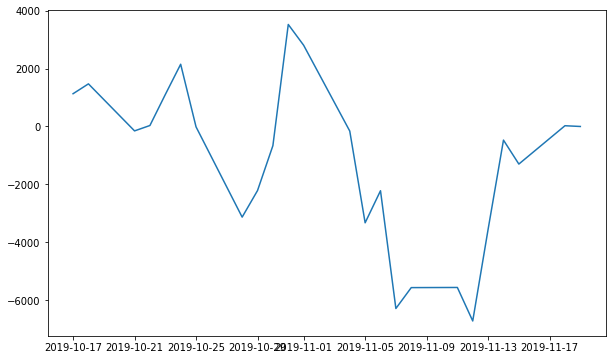

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(dynamic_price-fixed_price)